# Does the tail-end add value?

Should passive investors be happy with following a NIFTY 100 index or should they reach out below the mega-caps and consider the NIFTY 500?

In [2]:
library(DBI)
library(plutoDbR)
library(plutoR)
library(tidyverse)
options("scipen"=999)
options(stringsAsFactors = FALSE)
source("/usr/share/pluto/config.R")
source("/usr/share/pluto/goofy/plot.common.R")
source("/usr/share/pluto/goofy/misc.common.R")

library(pracma)
library(ggthemes)
library(reshape2)
library(quantmod)
library(lubridate)
library(ggrepel)
library(PerformanceAnalytics)
library(ggpubr)

options(repr.plot.width=16, repr.plot.height=8)
options(tibble.width = Inf)

indices<-Indices()

Collect NIFTY 100 and NIFTY 500 constituents

In [5]:
maxDt <- (indices$NseConstituents() %>%
            filter(NAME == "NIFTY 50") %>%
            summarize(MAX_TS = max(TIME_STAMP)) %>%
            collect())$MAX_TS[1]

n100 <- indices$NseConstituents() %>%
    filter(TIME_STAMP == maxDt & NAME == "NIFTY 100") %>%
    arrange(desc(CAP_WEIGHT)) %>%
    collect()
  
n500 <- indices$NseConstituents() %>%
    filter(TIME_STAMP == maxDt & NAME == "NIFTY 500") %>%
    arrange(desc(CAP_WEIGHT)) %>%
    collect()

How many stocks fall within 80% of cumulative market cap?

In [12]:
n100$C <- cumsum(n100$CAP_WEIGHT)
n500$C <- cumsum(n500$CAP_WEIGHT)

print(n100[n100$C <= 80,])
print(n500[n500$C <= 80,])

# A tibble: 35 x 6
   NAME      TIME_STAMP SYMBOL    INDUSTRY           CAP_WEIGHT     C
   <chr>     <chr>      <chr>     <chr>                   <dbl> <dbl>
 1 NIFTY 100 2019-11-04 HDFCBANK  FINANCIAL SERVICES       9.67  9.67
 2 NIFTY 100 2019-11-04 RELIANCE  ENERGY                   8.71 18.4 
 3 NIFTY 100 2019-11-04 HDFC      FINANCIAL SERVICES       6.50 24.9 
 4 NIFTY 100 2019-11-04 ICICIBANK FINANCIAL SERVICES       5.23 30.1 
 5 NIFTY 100 2019-11-04 INFY      IT                       4.89 35.0 
 6 NIFTY 100 2019-11-04 TCS       IT                       4.01 39.0 
 7 NIFTY 100 2019-11-04 ITC       CONSUMER GOODS           3.94 42.9 
 8 NIFTY 100 2019-11-04 KOTAKBANK FINANCIAL SERVICES       3.90 46.8 
 9 NIFTY 100 2019-11-04 LT        CONSTRUCTION             3.25 50.1 
10 NIFTY 100 2019-11-04 AXISBANK  FINANCIAL SERVICES       2.82 52.9 
# … with 25 more rows
# A tibble: 82 x 6
   NAME      TIME_STAMP SYMBOL    INDUSTRY           CAP_WEIGHT     C
   <chr>     <chr>      <chr> 

1. The top 35 stocks in the NIFTY 100 index and the top 82 stocks in the NIFTY 500 index comprise 80% of total weight.
1. Since both of these are free-float market-cap indices, there could be a set of high dividend paying stocks with lower cap-weights that affect the total-return of these indices. 

If returns are truly being accrued to the top stocks, then NIFTY 500 total returns should trail that of NIFTY 100.


In [14]:
nifty100Dt <- indices$NseTimeSeries() %>%
    filter(NAME == "NIFTY 100 TR") %>%
    select(TIME_STAMP, CLOSE) %>%
    collect() %>%
    mutate(TIME_STAMP = as.Date(TIME_STAMP))

nifty500Dt <- indices$NseTimeSeries() %>%
    filter(NAME == "NIFTY 500 TR") %>%
    select(TIME_STAMP, CLOSE) %>%
    collect() %>%
    mutate(TIME_STAMP = as.Date(TIME_STAMP))

dailyRets <- na.omit(merge(dailyReturn(xts(nifty100Dt$CLOSE, nifty100Dt$TIME_STAMP)), dailyReturn(xts(nifty500Dt$CLOSE, nifty500Dt$TIME_STAMP))))
annRets <- 100*na.omit(merge(annualReturn(xts(nifty100Dt$CLOSE, nifty100Dt$TIME_STAMP)), annualReturn(xts(nifty500Dt$CLOSE, nifty500Dt$TIME_STAMP))))

In [15]:
names(dailyRets) <- c('N100', 'N500')

annualDf <- data.frame(annRets)
names(annualDf) <- c('N100', 'N500')

annualDf$YEAR <- year(index(annRets))
print(annualDf)

                 N100        N500 YEAR
2003-12-31  86.877000 104.8540686 2003
2004-12-31  16.327317  21.0733507 2004
2005-12-30  37.139414  38.7687292 2005
2006-12-29  40.244393  36.1602013 2006
2007-12-31  59.476926  64.5818895 2007
2008-12-31 -53.074848 -56.5406639 2008
2009-12-31  84.880532  90.9632300 2009
2010-12-31  19.280549  15.2697287 2010
2011-12-30 -24.932862 -26.3962917 2011
2012-12-31  32.506699  33.4776895 2012
2013-12-31   7.885048   4.8221010 2013
2014-12-31  34.879770  39.2984303 2014
2015-12-31  -1.255502   0.2236637 2015
2016-12-30   5.009608   5.1242453 2016
2017-12-29  32.877232  37.6545466 2017
2018-12-31   2.565001  -2.1365110 2018
2019-11-04  10.173181   7.3876049 2019


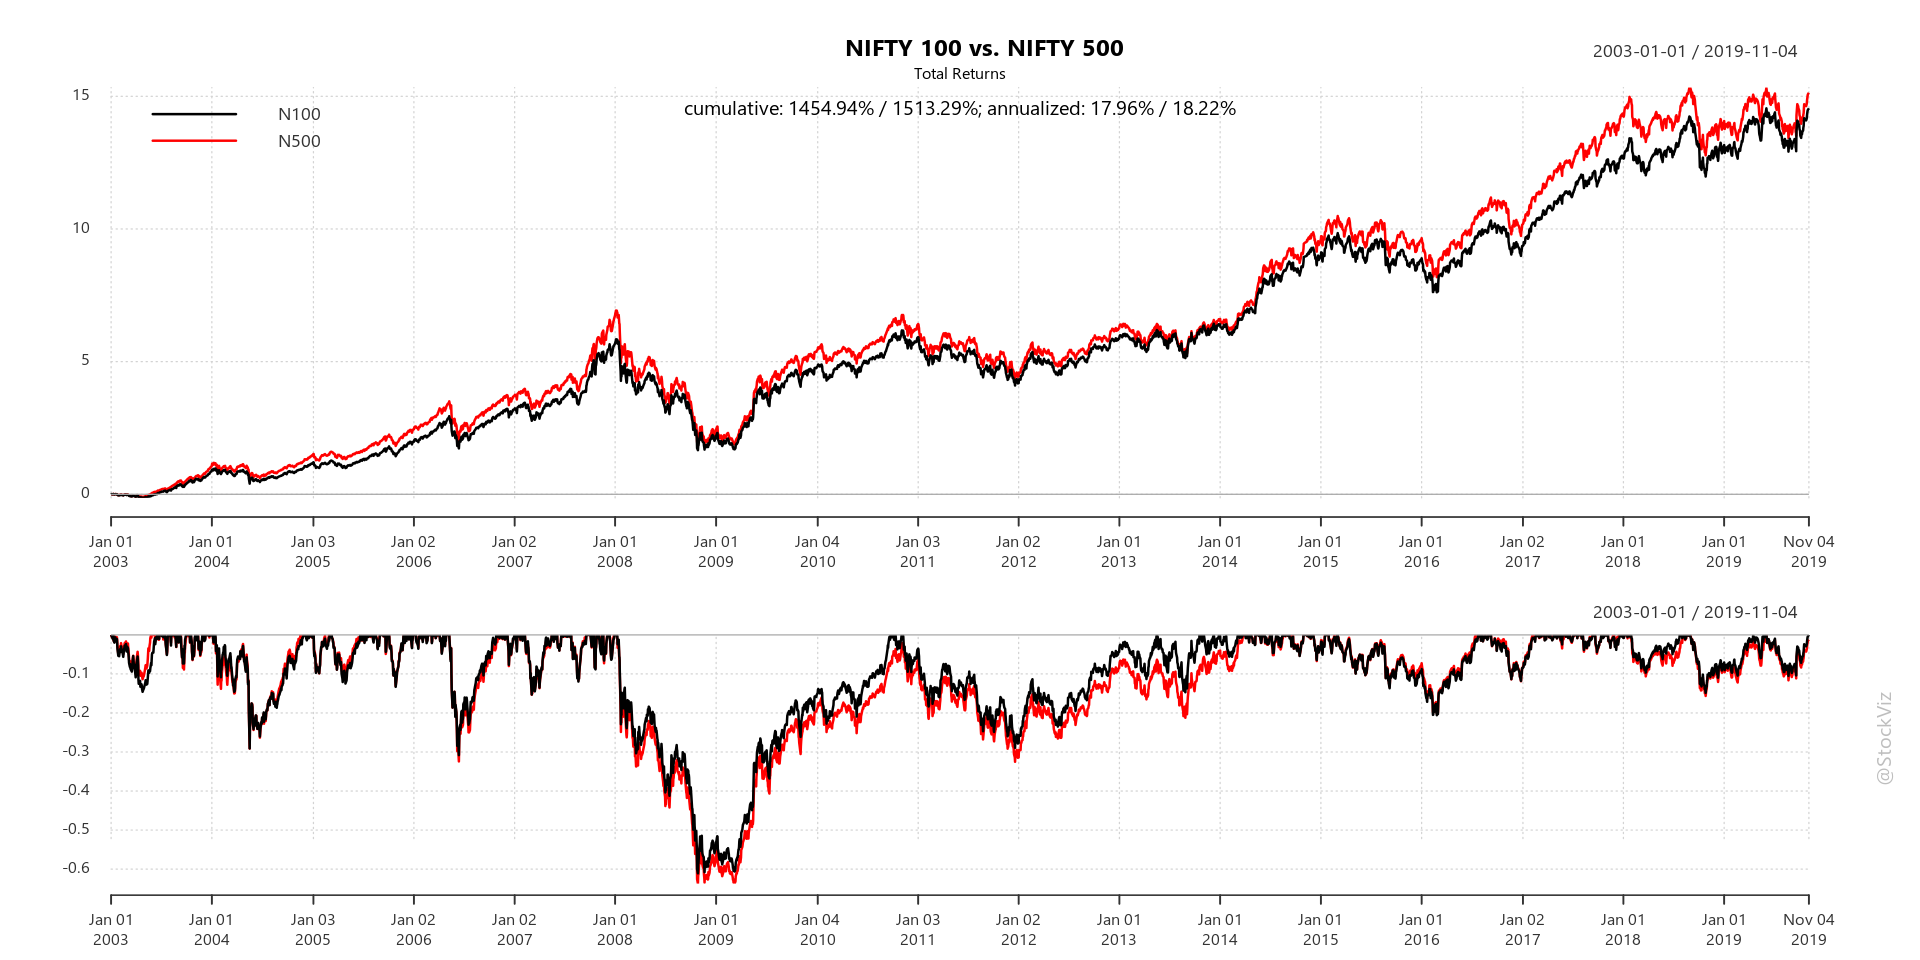

In [16]:
Common.PlotCumReturns(dailyRets, "NIFTY 100 vs. NIFTY 500", "Total Returns")

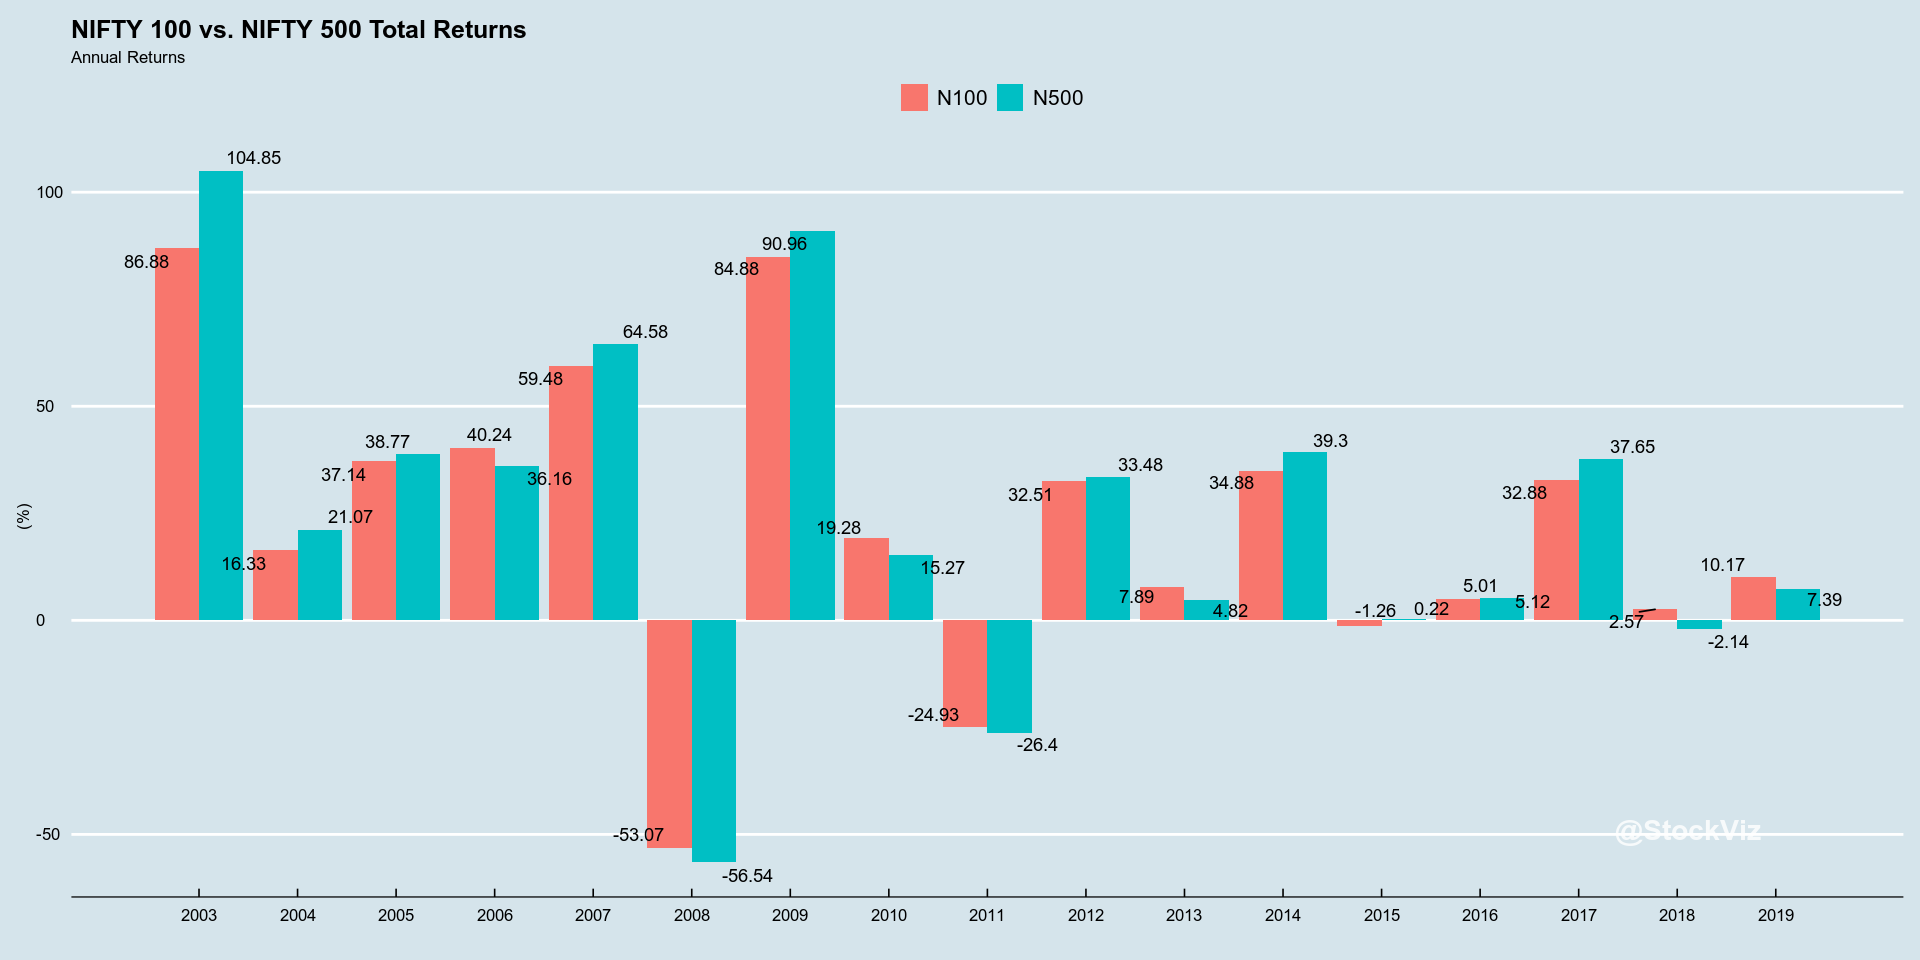

In [19]:
mDf <- melt(annualDf, id='YEAR')
ggplot(mDf, aes(x=YEAR, y=value, fill=variable)) +
    theme_economist() +
    geom_bar(stat="identity", position=position_dodge()) +
    scale_x_continuous(labels=annualDf$YEAR, breaks=annualDf$YEAR) +
    geom_text_repel(aes(label= round(value, 2)), position = position_dodge(0.9)) +
    labs(x='', y='(%)', fill='', title="NIFTY 100 vs. NIFTY 500 Total Returns", subtitle="Annual Returns") +
    annotate("text", x=max(annualDf$YEAR), y=min(mDf$value), 
             label = "@StockViz", hjust=1.1, vjust=-1.1, 
             col="white", cex=6, fontface = "bold", alpha = 0.8)  

This notebook was created using [pluto](https://pluto.studio). Thank you for playing fair!